In [1]:
import sys
import os
sys.path.insert(0, '/Users/lerinalaluf/Desktop/SIP_2021/kaepora/src')
os.chdir('/Users/lerinalaluf/Desktop/SIP_2021/kaepora/src')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import kaepora as kpora
import numpy as np
import matplotlib.pyplot as plt

In [4]:
spectra_query = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase <= 200 and ((dm15_source < 1.1 and dm15_source > 1) or (dm15_from_fits < 1.1 and dm15_from_fits > 1)) and (si_v0 < -10000 and si_v0 > -11000)"]

In [5]:
spec_array = kpora.grab(spectra_query[0], db_file = '../data/kaepora_v1_DEV.db', make_corr = True)

239 Total Spectra found
8 flagged spectra removed 231 spectra left
0 spectra of peculiar Ias removed 231 spectra left
231 spectra of SNe that have host reddening corrections
Arrays cleaned


In [6]:
def fluxGrid(spec_array):
    
    MINSTART = spec_array[0].x1
    MINEND = spec_array[0].x2

    for spec in spec_array:
        if spec.x1 < MINSTART:
            MINSTART = spec.x1
        if spec.x2 > MINEND:
            MINEND = spec.x2
    
    all_data = 0.0

    for spec in spec_array:
        all_data += len(spec.flux[~np.isnan(spec.flux)])
    
    length = len(spec_array[0].flux[~np.isnan(spec_array[0].flux)])

    for spec in spec_array:
        if length > len(spec.flux[~np.isnan(spec.flux)]):
            length = len(spec.flux[~np.isnan(spec.flux)])
    
    total_data = all_data
    data_percent = 0.0

    start = MINSTART

    bestStart = None
    bestLength = None

    while (start + length - 1 <= MINEND):
        total_data = all_data

        while (start + length - 1 <= MINEND):
            num_cols = len(spec_array)
            
            for spec in spec_array:
                array_start = spec.flux[:start]
                array_end = spec.flux[(start + length - 1):]
                new_array = spec.flux[start:(start + length)]

                total_data -= len(array_start[~np.isnan(array_start)])
                total_data -= len(array_end[~np.isnan(array_end)])

                if any(np.isnan(new_array)):
                    total_data -= len(new_array[~np.isnan(new_array)])
                    num_cols -= 1

            new_data = total_data/all_data

            if new_data > data_percent:
                data_percent = new_data
                bestStart = start
                bestLength = length
                best_num_cols = num_cols

            total_data = all_data
            start += 100

        start = MINSTART 
        length += 100
    
    MIN = bestStart
    MAX = bestStart + bestLength - 1

    num_rows = bestLength
    num_cols = best_num_cols
    
    grid = []
    k = 0
    
    while len(grid) < num_cols:
        if any(np.isnan(spec_array[k].flux)[MIN:(MAX + 1)]):
            spec_array.pop(k)
        if all(~np.isnan(spec_array[k].flux)[MIN:(MAX + 1)]):
            grid.append(spec_array[k].flux[MIN:(MAX + 1)])
            k += 1
    
    print num_cols
    np.savetxt('../../Filtered_Flux_Grid_Phase', grid)
    
    print (MIN, MAX)
    
    print (spec_array[0].wavelength[MIN], spec_array[0].wavelength[MAX])
    return (MIN, MAX, grid)

In [7]:
MIN, MAX, grid = fluxGrid(spec_array)
spec_array = spec_array[:len(grid)]

196
(1364, 3059)
(3728.0, 7118.0)


After Sequencer:

In [8]:
data = np.loadtxt("../../Phase_Sequence")
data = data.astype(int)
print data

[134 135  43  40  38  42  41  37 166  39  36 167  34 168  35  33 164 195
 163 191 193 161 194 192  28  78   4  29 187 189  79  30 188  62  99 165
 190  31  74  77  32  61  76  72  73  75  47 156 159 183 181 184 157  21
 182  85  93 185 180  22 155 158 186  86  23 121  46  45  98 123 119  25
 179 160  52 124 178  26 115 154  24  53 125 114 153 116  27  97 128 177
 118   3 102 130 117 113 104  20  71 131 129 112  19 120  96   2 127 122
 111 132 126  18 110 133 109 108 151 150  90 149  91 101 148  59  92  67
  89  68  60  69  70  88 147 152  49 146 176  12  51 175   0  13  10 145
  14   9  15  11 144   8  84   1 143 174   7  58 142  16   6  63  64  87
 103   5  65  17 141  48  50 140  66 105 106 173  83 107 172  82 138  56
  55 100 171  57  81  54  80 137  94 170  95 136 162 169 139  44]


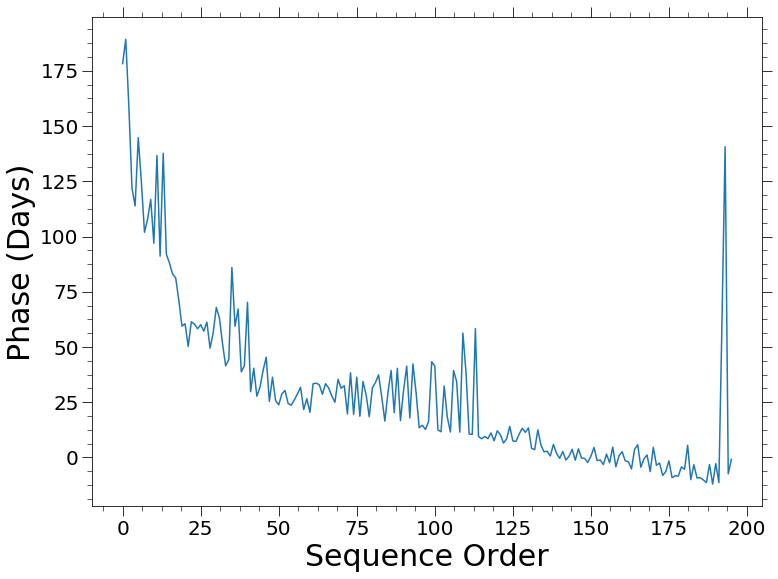

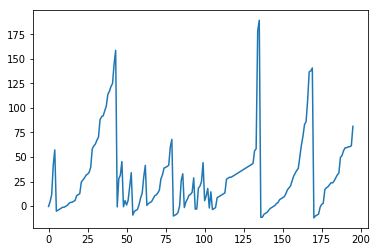

In [9]:
ordered_array = []

for i in data:
    ordered_array.append(spec_array[i].phase)

plt.figure(figsize=(12,9))
plt.xlabel("Sequence Order", fontsize = 30)
plt.ylabel("Phase (Days)", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.plot(ordered_array)
plt.savefig('../../Phase_Plot.png', dpi = 300, bbox_inches = 'tight')
plt.show()

unordered_array = []

for spec in spec_array:
    unordered_array.append(spec.phase)

plt.plot(unordered_array)
plt.show()

Outlier Diagnostic Tools:

193 140.664001018


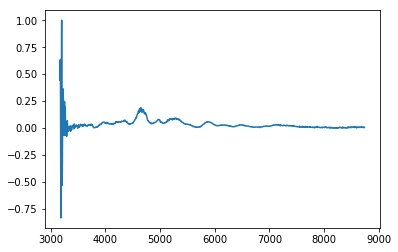

In [10]:
outlier_estimate = 192
y = 125

i = outlier_estimate - 5
k = outlier_estimate + 5

if k >= len(spec_array):
    k = len(spec_array) - 1

if i < 0:
    i = 0

while i <= k:
    if spec_array[data[i]].phase > y:
        wavelength = spec_array[data[i]].wavelength
        flux = spec_array[data[i]].flux
        plt.plot(wavelength, flux)
        print i, spec_array[data[i]].phase
    i += 1

195 -0.861378297777
194 -7.39081702412
193 140.664001018
192 62.1651377605
191 -11.3654430118
190 -2.80966085164


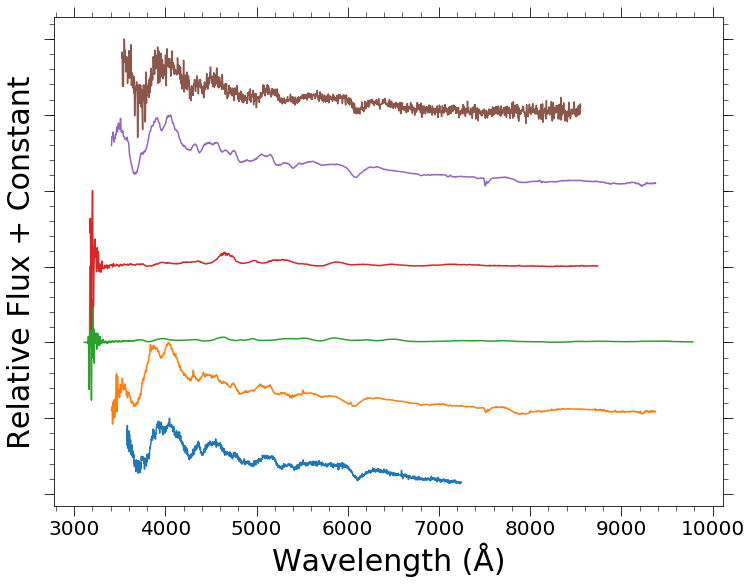

In [11]:
outlier = 193

i = outlier - 3
k = outlier + 3
j = 0

if k >= len(spec_array):
    k = len(spec_array) - 1

if i < 0:
    i = 0

plt.figure(figsize=(12,9))
plt.xlabel(u"Wavelength (Å)", fontsize = 30)
plt.ylabel("Relative Flux + Constant", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.gca().axes.yaxis.set_ticklabels([])

while i <= k:
    wavelength = spec_array[data[i]].wavelength
    flux = spec_array[data[i]].flux
    plt.plot(wavelength, flux + j)
    print k - j, spec_array[data[k - j]].phase
    i += 1
    j += 1

plt.show()

Composites:

In [12]:
num_comp = 10

file_name_array = []
k = 0

while k < len(data):
    farray = []
    for i in data[k:k+len(data)/num_comp]:
        farray.append(spec_array[i].filename)
    file_name_array.append(farray)
    k += len(data)/num_comp

query_strings = []

for files in file_name_array:
    i = 1
    string = "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where "
    for file in files:
        string += "filename = '%s'"% (file)
        if i < len(files):
            string += ' or '
        i += 1
    query_strings.append(string)

composites, sn_arrays, boot_sn_arrays = kpora.make_composite(query_strings, boot=False, medmean=1, gini_balance=True, verbose=False, shape_param='dm15', av_corr = False)

SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where filename = 'sn1998bu-19981114.51-fast.flm' or filename = 'sn1998bu-19981125.54-fast.flm' or filename = 'sn2007af-20070821.210-ui.flm' or filename = 'sn2007af-20070715.213-ui.flm' or filename = 'sn2007af-20070707.205-ui.flm' or filename = 'sn2007af-20070807.214-ui.flm' or filename = 'sn2007af-20070718.21-fast.flm' or filename = 'sn2007af-20070625.17-fast.flm' or filename = '2003du_20030823_3494_7818_00.dat' or filename = 'sn2007af-20070710.17-fast.flm' or filename = 'sn2007af-20070620.18-fast.flm' or filename = '2003du_20030921_3676_9050_00.dat' or filename = 'sn2007af-20070614.314-ui.flm' or filename = '2003du_20030922_3676_9051_00.dat' or filename = 'sn2007af-20070615.21-fast.flm' or filename = 'sn2007af-20070611.20-fast.flm' or filename = '2003du_20030729_3350_10300_00.dat' or filename = 'sn2003du-20030727-ui.flm' or filename = '2003du_20030717_3499_10250_00.dat'
19 Total Spectra found
0 flagged spectr

19 Total Spectra found
0 flagged spectra removed 19 spectra left
0 spectra of peculiar Ias removed 19 spectra left
19 spectra of SNe that have host reddening corrections
Arrays cleaned
19 spectra may have telluric contamination
5 total SNe
removed spectra of SNe with A_V > 2.0
Using 19 spectra of 5 SNe
Gini balancing...
Balanced after 9 iterations
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where filename = '2003du_20030519_3477_9734_00.dat' or filename = 'sn2006mp-20061120.101-ui.flm' or filename = '2003du_20030509_3402_10011_00.dat' or filename = 'sn2003du-20030509.29-fast.flm' or filename = 'sn2007af-20070315.39-fast.flm' or filename = 'SN08bq_080412_b01_DUP_WF.dat' or filename = 'sn2003du-20030508.30-fast.flm' or filename = 'SN07af_070314_b01_DUP_BC.dat' or filename = 'sn2007af-20070317.42-fast.flm' or filename = 'sn2007af-20070313.545-ui-corrected.flm' or filename = '2003du_20030507_3404_10096_00.dat' or filename = 'sn2007af-20070318.41-fast.flm' o

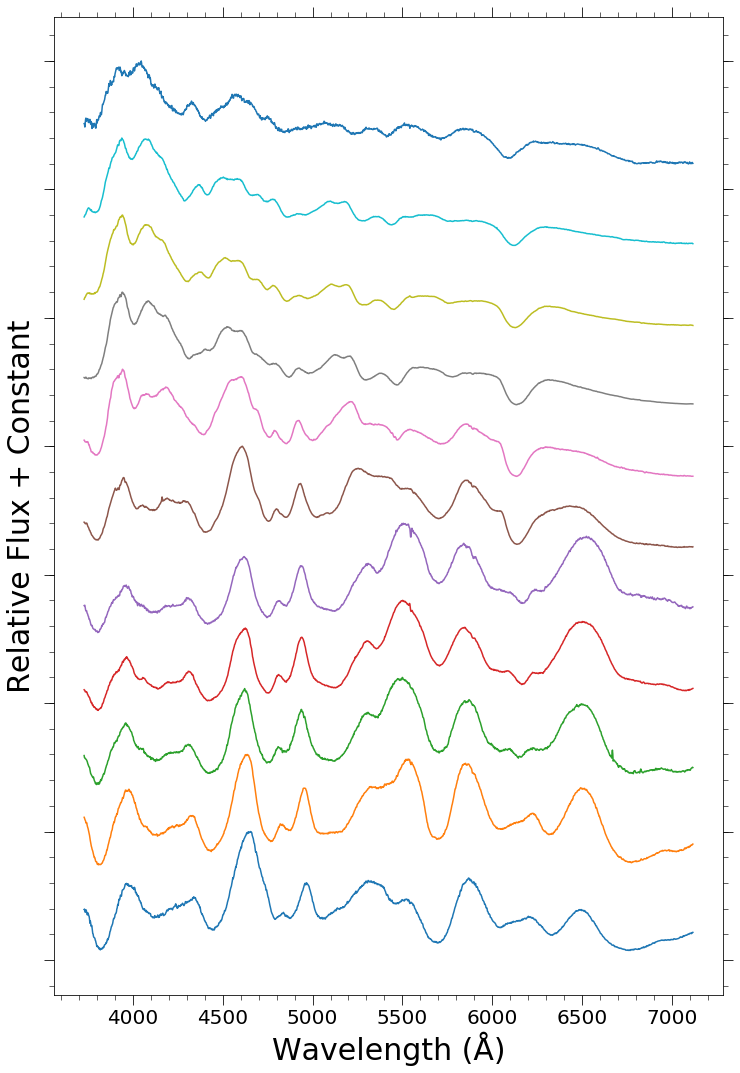

In [14]:
plt.figure(figsize=(12,18))
plt.xlabel(u"Wavelength (Å)", fontsize = 30)
plt.ylabel("Relative Flux + Constant", fontsize = 30)

plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.gca().axes.yaxis.set_ticklabels([])

k = 0

for composite in composites:
    wavelength = composite.wavelength[MIN:(MAX + 1)]
    flux = composite.flux[MIN:(MAX + 1)]
    plt.plot(wavelength, flux + k)
    k += 0.6

plt.savefig('../../Phase_Composites.png', dpi = 300, bbox_inches = 'tight')
plt.show()